# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [77]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

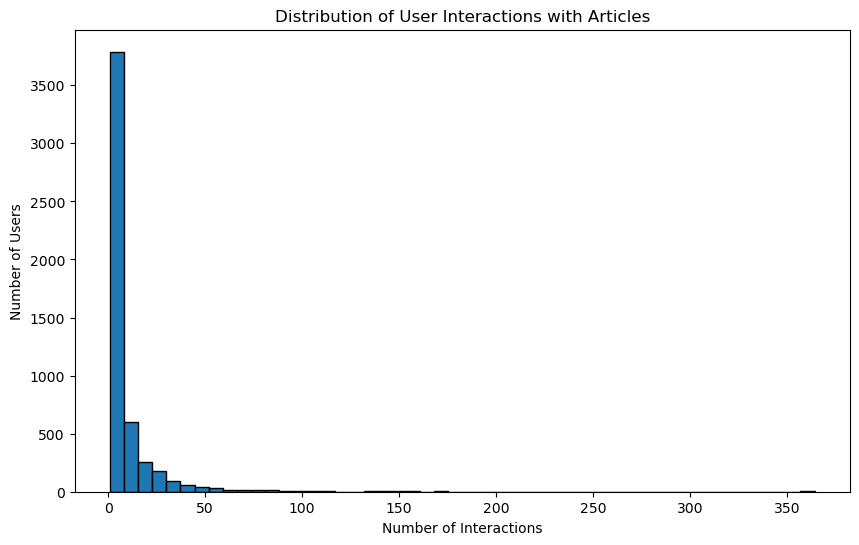

In [78]:
user_interactions = df.groupby('email')['article_id'].count()

plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=50, edgecolor='k')
plt.title('Distribution of User Interactions with Articles')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()


In [79]:
user_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [80]:
duplicate_articles = df_content[df_content.duplicated(subset='article_id')]

df_content = df_content.drop_duplicates(subset='article_id')

len(duplicate_articles)

5

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [81]:
unique_articles_interacted = df['article_id'].nunique()

unique_articles_total = df_content['article_id'].nunique()

unique_users = df['email'].nunique()

total_interactions = df.shape[0]

unique_articles_interacted, unique_articles_total, unique_users, total_interactions


(714, 1051, 5148, 45993)

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [82]:
most_viewed_article = df['article_id'].value_counts().idxmax()

In [83]:
null_emails = df['email'].isnull().sum()
null_emails

17

In [84]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [86]:
unique_articles = df['article_id'].nunique()
total_articles = df_content['article_id'].nunique()
unique_users = int(df['user_id'].nunique() - (1 if null_emails > 0 else 0))
user_article_interactions = df.shape[0]
median_val = df.groupby('user_id')['article_id'].count().median()
max_views_by_user = df.groupby('user_id')['article_id'].count().max()
max_views = df['article_id'].value_counts().max()
most_viewed_article_id = str(most_viewed_article)

In [87]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [88]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().head(n).index.tolist()
    
    top_articles = df[df['article_id'].isin(top_articles)]['title'].unique().tolist()[:n]
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = df['article_id'].value_counts().head(n).index.tolist()
    
    return top_articles

In [89]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [90]:
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [91]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    
    user_item = user_item.notnull().astype(int)
    
    return user_item

user_item = create_user_item_matrix(df)

user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [93]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of users where the closest users (largest dot product users) are listed first
    '''
    user_vector = user_item.loc[user_id].values
    similarity = user_item.dot(user_vector)
    
    similarity_df = similarity.reset_index()
    similarity_df.columns = ['user_id', 'similarity']
    
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    
    most_similar_users = similarity_df['user_id'].tolist()
    
    most_similar_users.remove(user_id)
       
    return most_similar_users

In [94]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [107]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids (str)
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list
                     of article ids (this is identified by the title column)
    '''
    article_ids_float = {float(article_id) for article_id in article_ids}

    article_id_to_title = dict(zip(df['article_id'], df['title']))

    article_names = [article_id_to_title[article_id] for article_id in article_ids_float if article_id in article_id_to_title]

    return article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with
                    the list of article ids

    Description:
    Provides a list of the article_ids and article titles that have
    been seen by a user
    '''
    interacted_articles = user_item.loc[user_id]
    article_ids = interacted_articles[interacted_articles > 0].index.astype(str).tolist()

    article_names = get_article_names(article_ids)

    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and
                    provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    seen_articles, _ = get_user_articles(user_id)

    similar_users = find_similar_users(user_id)

    recs = set()

    for sim_user in similar_users:
        if len(recs) >= m:
            break

        sim_user_articles, _ = get_user_articles(sim_user)

        new_recs = set(sim_user_articles) - set(seen_articles) - recs
        recs.update(new_recs)

    return list(recs)[:m]


In [108]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['movie recommender system with spark machine learning',
 'aspiring data scientists! start to learn statistics with these 6 books!',
 'analyze open data sets with pandas dataframes',
 'from scikit-learn model to cloud with wml client',
 'predicting churn with the spss random tree algorithm',
 'programmatic evaluation using watson conversation',
 'build a python app on the streaming analytics service',
 'working with db2 warehouse on cloud in data science experience',
 'declarative machine learning',
 'how smart catalogs can turn the big data flood into an ocean of opportunity']

In [109]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [110]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
    '''
    user_vector = user_item.loc[user_id]
    similarity = user_item.dot(user_vector)
    
    num_interactions = df.groupby('user_id').size()
    
    neighbors_df = pd.DataFrame({'neighbor_id': similarity.index, 'similarity': similarity.values})
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].map(num_interactions)
    
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df



def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    top_users = get_top_sorted_users(user_id, df, user_item)
    
    seen_articles, _ = get_user_articles(user_id, user_item)
    
    recs = []
    
    for neighbor_id in top_users['neighbor_id']:
        if len(recs) >= m:
            break
        
        neighbor_articles, _ = get_user_articles(neighbor_id, user_item)
        
        new_recs = [article for article in neighbor_articles if article not in seen_articles and article not in recs]
        
        article_counts = df['article_id'].value_counts()
        new_recs = sorted(new_recs, key=lambda x: article_counts.get(float(x), 0), reverse=True)
        
        recs.extend(new_recs)
    
    rec_names = get_article_names(recs[:m])
    
    return recs[:m], rec_names


In [111]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['putting a human face on machine learning', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'movie recommender system with spark machine learning', 'insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [112]:
top_sorted_users_user1 = get_top_sorted_users(1, df, user_item)
user1_most_sim = top_sorted_users_user1.iloc[0]['neighbor_id']

top_sorted_users_user131 = get_top_sorted_users(131, df, user_item)
user131_10th_sim = top_sorted_users_user131.iloc[9]['neighbor_id']

In [113]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

### Recommendations for New Users

For new users without interaction history, user-user collaborative filtering won't work. Instead, we can use the following methods:

**1. Popular Articles**:
   - Use the `get_top_articles` function to recommend the most popular articles based on overall interaction data. This function ranks articles by the number of interactions and selects the top ones.

**2. Content-Based Filtering**:
   - If we have initial user preferences (e.g., topics of interest), we can recommend articles that match these preferences. This involves filtering articles by keywords or categories and suggesting those that align with the user's interests.

**3. Hybrid Approach**:
   - Combine the above methods by initially recommending popular articles and refining recommendations based on user preferences as we gather more data about their interactions.

**4. Demographic-Based Recommendations**:
   - Use demographic information (if available) to provide recommendations. For example, recommend articles popular among users of similar age or location.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [118]:
new_user = '0.0'

new_user_recs = [str(x) for x in get_top_article_ids(10)]

In [119]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [120]:
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [121]:
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [122]:
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

**Provide your response here.**

### Explanation of SVD Results

1. **`u` matrix**: Shape (5149, 714) - Represents users in the latent space.
2. **`s` matrix**: Shape (714,) - Diagonal matrix with singular values.
3. **`vt` matrix**: Shape (714, 714) - Represents items (articles) in the latent space.

### Difference from Lesson

In the lesson, collaborative filtering was used to predict ratings based on user interactions. Here, we use SVD to decompose the user-item matrix, capturing latent factors that represent underlying patterns in user preferences and item characteristics. This method uncovers hidden relationships, making it effective for sparse matrices.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

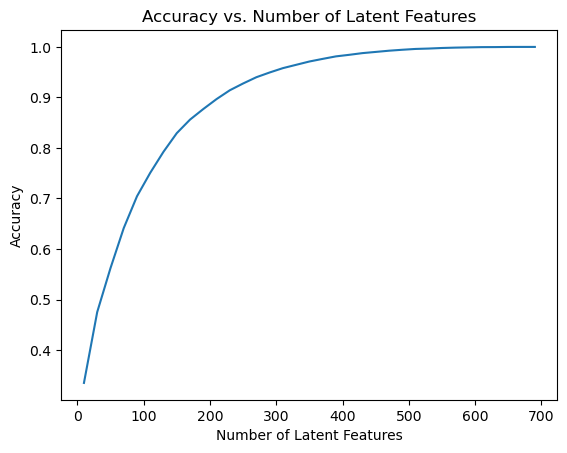

In [123]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [127]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    '''
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)
    
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [129]:
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

train_idx = user_item_train.index
pred_users = len(np.intersect1d(test_idx, train_idx))

cold_start_users = len(test_idx) - pred_users

train_arts = user_item_train.columns
pred_articles = len(np.intersect1d(test_arts, train_arts))

cold_start_articles = len(test_arts) - pred_articles

pred_users, cold_start_users, pred_articles, cold_start_articles

(20, 662, 574, 0)

In [130]:
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [131]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [132]:
train_idx = user_item_train.index
test_idx = user_item_test.index
common_users = np.intersect1d(test_idx, train_idx)

train_arts = user_item_train.columns
test_arts = user_item_test.columns
common_articles = np.intersect1d(test_arts, train_arts)

user_item_test_common = user_item_test.loc[common_users, common_articles]

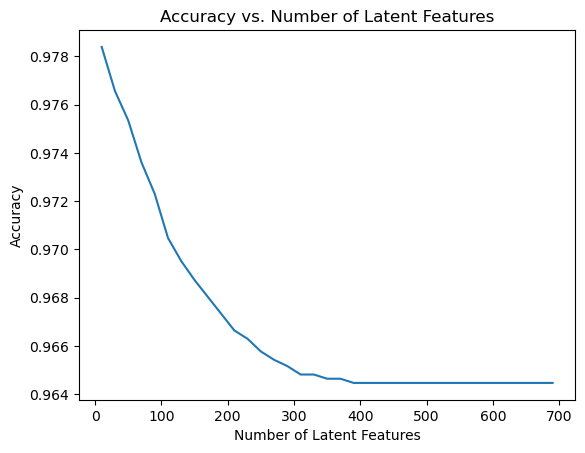

In [133]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

accuracy_list = []

for k in num_latent_feats:
    s_k = np.diag(s_train[:k])
    u_k = u_train[:, :k]
    vt_k = vt_train[:k, :]
    
    user_item_est = np.dot(np.dot(u_k, s_k), vt_k)
    
    user_item_est_common = pd.DataFrame(user_item_est, index=user_item_train.index, columns=user_item_train.columns)
    user_item_est_common = user_item_est_common.loc[common_users, common_articles]
    
    user_item_est_common = user_item_est_common.applymap(lambda x: 1 if x >= 0.5 else 0)
    
    diffs = np.subtract(user_item_test_common.values, user_item_est_common.values)
    err = np.sum(np.abs(diffs))
    sum_errs.append(err)
    
    accuracy = 1 - (err / user_item_test_common.size)
    accuracy_list.append(accuracy)

plt.plot(num_latent_feats, accuracy_list)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

**Accuracy**:
- Increased latent features improved accuracy initially.
- Beyond a point, additional features provided minimal gains.

### Steps to Validate Improvement

1. **A/B Testing**:
   - Compare new and current systems.
   - Measure click-through rate, engagement, and conversion.

2. **User Feedback**:
   - Collect survey responses and ratings on recommendations.

3. **Engagement Metrics**:
   - Track article views and return rates.

4. **Address Cold Start**:
   - Use content-based or demographic recommendations for new users.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to', 'html', 'Recommendations_with_IBM.ipynb'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 505985 bytes to Recommendations_with_IBM.html


0